In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
from pandas import read_csv, DataFrame
from pathlib import Path
import statsmodels.api as sm
from statsmodels.formula.api import ols
from numpy import nan
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas import to_numeric
from numpy import sqrt
from numpy import arange
from pandas import notna
import pandas as pd
import pingouin as pg

In [3]:
subset_name_to_title = {
    "in_domain_wo_other": "In-Domain without OTHER",
    "in_domain_w_other": "In-Domain with OTHER",
    "cross_domain_wo_other": "Cross-Domain without OTHER",
    "cross_domain_w_other": "Cross-Domain with OTHER",
}
mappings = {
    "textualizers": {
        "CivitareseTextualSummary": "CTS",
        "CompoundTextualSummary": "CSS",
        "DhekaneTextualSummary": "DTS",
        "TDOSTPlainBasic": "TPB",
        "TDOSTPlainTemporal": "TPT",
        "TDOSTSeqBasic": "TSB",
        "TDOSTSeqTemporal": "TST",
    },
    "encoders": {
        "SentenceTransformersVectorizer": "SBERT",
        "TfidfVectorizer": "TF-IDF",
        "Word2VecVectorizer": "Word2Vec",
    },
    "datasets": {
        "TestBed.ORDA": "Ordonez-A",
        "TestBed.ORDB": "Ordonez-B",
        "TestBed.CASA": "CASAS-Aruba",
        "TestBed.CASM": "CASAS-Milan",
    },
}


def get_combined_anova_table(subsets: dict[str, DataFrame]) -> DataFrame:
    def partial_eta_squared(ss_effect, ss_resid):
        return ss_effect / (ss_effect + ss_resid) if (ss_effect + ss_resid) > 0 else nan

    rows = []
    for name, sub in subsets.items():
        sub = sub.copy()
        sub["textualizer"] = sub["textualizer"].astype("category")
        sub["encoder"] = sub["encoder"].astype("category")
        model = ols("balanced_accuracy ~ C(textualizer) * C(encoder)", data=sub).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        ss_resid = anova_table.loc["Residual", "sum_sq"]
        for effect_name, effect_label in [
            ("C(textualizer)", "Textualizer"),
            ("C(encoder)", "Encoder"),
            ("C(textualizer):C(encoder)", "Interaction"),
        ]:
            if effect_name in anova_table.index:
                row_data = anova_table.loc[effect_name]
                f_val = row_data["F"]
                p_val = row_data["PR(>F)"]
                eta2 = partial_eta_squared(row_data["sum_sq"], ss_resid)
                rows.append(
                    {
                        "Cell": subset_name_to_title[name],
                        "Effect": effect_label,
                        "F": f"{f_val:.3f}",
                        "p": f"{p_val:.3f}",
                        "$\\eta^2_p$": f"{eta2:.3f}",
                    }
                )
    combined_df = DataFrame(rows)
    return combined_df


def convert_anova_results_to_latex(anova_df: DataFrame) -> str:
    lines = []
    lines.append("\\begin{table}[htbp]")
    lines.append("\\centering")
    lines.append("\\setlength\\tabcolsep{0pt}")
    lines.append(
        "\\caption{Two-way ANOVA (Type-II) per (setting, realism). We report $F$, $p$, and partial $\\eta^2_p$; residual df are omitted for brevity.}"
    )
    lines.append("\\label{tab:anova_combined}")
    lines.append("\\begin{tabular*}{\\columnwidth{@{}clccc@{}}")
    lines.append("\\toprule")
    lines.append(
        "\\textbf{Cell} & \\textbf{Effect} & \\textbf{F} & \\textbf{p} & \\boldmath$\\eta^2_p$ \\\\"
    )
    lines.append("\\midrule")
    current_cell = None
    cell_count = 0
    for idx, row in anova_df.iterrows():
        cell = row["Cell"]
        if cell != current_cell:
            if cell_count > 0:
                lines.append("\\midrule")
            lines.append(
                f"\\multicolumn{{1}}{{c}}{{{cell}}} & {row['Effect']} & {row['F']} & {row['p']} & {row['$\\eta^2_p$']} \\\\"
            )
            current_cell = cell
            cell_count += 1
        else:
            lines.append(
                f" & {row['Effect']} & {row['F']} & {row['p']} & {row['$\\eta^2_p$']} \\\\"
            )
    lines.append("\\bottomrule")
    lines.append("\\end{tabular*}")
    lines.append("\\end{table}")
    latex_content = "\n".join(lines)
    return latex_content


def get_top_configs_table(
    df_wo_other: DataFrame, df_w_other: DataFrame, k: int = 5
) -> DataFrame:
    grouped_wo = (
        df_wo_other.groupby(["textualizer", "encoder"])["balanced_accuracy"]
        .mean()
        .reset_index()
    )
    top_wo = grouped_wo.nlargest(k, "balanced_accuracy")
    top_wo["realism"] = "No OTHER"
    grouped_w = (
        df_w_other.groupby(["textualizer", "encoder"])["balanced_accuracy"]
        .mean()
        .reset_index()
    )
    top_w = grouped_w.nlargest(k, "balanced_accuracy")
    top_w["realism"] = "With OTHER"
    combined = []
    for _, row in top_wo.iterrows():
        combined.append(
            {
                "Realism": row["realism"],
                "Textualizer + Encoder": f"{row['textualizer']}+{row['encoder']}",
                "BA": f"{row['balanced_accuracy']:.4f}",
            }
        )
    for _, row in top_w.iterrows():
        combined.append(
            {
                "Realism": row["realism"],
                "Textualizer + Encoder": f"{row['textualizer']}+{row['encoder']}",
                "BA": f"{row['balanced_accuracy']:.4f}",
            }
        )
    return DataFrame(combined)


def convert_top_configs_to_latex(top_df: DataFrame, caption: str, label: str) -> str:
    lines = []
    lines.append("\\begin{table}[htbp]")
    lines.append("\\centering")
    lines.append("\\setlength\\tabcolsep{0pt}")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append("\\begin{tabular*}{\\columnwidth}{@{}llc@{}}")
    lines.append("\\toprule")
    lines.append(
        "\\textbf{Realism} & \\textbf{Textualizer + Encoder} & \\textbf{BA} \\\\"
    )
    lines.append("\\midrule")
    current_realism = None
    realism_count = 0
    for idx, row in top_df.iterrows():
        realism = row["Realism"]
        if realism != current_realism:
            if current_realism is not None:
                lines.append("\\midrule")
            current_realism = realism
            realism_count = top_df[top_df["Realism"] == realism].shape[0]
            lines.append(
                f"\\multirow{{{realism_count}}}{{*}}{{{realism}}} & {row['Textualizer + Encoder']} & {row['BA']} \\\\"
            )
        else:
            lines.append(f" & {row['Textualizer + Encoder']} & {row['BA']} \\\\")
    lines.append("\\bottomrule")
    lines.append("\\end{tabular*}")
    lines.append("\\end{table}")
    return "\n".join(lines)

In [4]:
outdir = Path("../output/paper")
outdir.mkdir(exist_ok=True, parents=True)
input_file_path = Path("../imported/tidy_results.csv")
df = read_csv(input_file_path)
df["textualizer"] = df["textualizer"].map(mappings["textualizers"])
df["encoder"] = df["encoder"].map(mappings["encoders"])
df["source"] = df["source"].map(mappings["datasets"])
df["target"] = df["target"].map(mappings["datasets"])
subsets = {
    "in_domain_wo_other": df[(df["setting"] == "in_domain") & (~df["use_other"])],
    "in_domain_w_other": df[(df["setting"] == "in_domain") & (df["use_other"])],
    "cross_domain_wo_other": df[(df["setting"] == "cross_domain") & (~df["use_other"])],
    "cross_domain_w_other": df[(df["setting"] == "cross_domain") & (df["use_other"])],
}

In [5]:
anova_results = get_combined_anova_table(subsets)
display(anova_results)
anova_latex_table = convert_anova_results_to_latex(anova_results)
print(anova_latex_table)

,Cell,Effect,F,p,$\eta^2_p$
0,In-Domain without OTHER,Textualizer,3.375,0.006,0.243
1,In-Domain without OTHER,Encoder,1.035,0.361,0.032
2,In-Domain without OTHER,Interaction,0.423,0.949,0.075
3,In-Domain with OTHER,Textualizer,1.418,0.222,0.119
4,In-Domain with OTHER,Encoder,0.350,0.706,0.011
5,In-Domain with OTHER,Interaction,0.355,0.974,0.063
6,Cross-Domain without OTHER,Textualizer,4.072,0.001,0.096
7,Cross-Domain without OTHER,Encoder,0.036,0.964,0.000
8,Cross-Domain without OTHER,Interaction,0.960,0.488,0.047
9,Cross-Domain with OTHER,Textualizer,1.195,0.310,0.030


\begin{table}[htbp]
\centering
\setlength\tabcolsep{0pt}
\caption{Two-way ANOVA (Type-II) per (setting, realism). We report $F$, $p$, and partial $\eta^2_p$; residual df are omitted for brevity.}
\label{tab:anova_combined}
\begin{tabular*}{\columnwidth{@{}clccc@{}}
\toprule
\textbf{Cell} & \textbf{Effect} & \textbf{F} & \textbf{p} & \boldmath$\eta^2_p$ \\
\midrule
\multicolumn{1}{c}{In-Domain without OTHER} & Textualizer & 3.375 & 0.006 & 0.243 \\
 & Encoder & 1.035 & 0.361 & 0.032 \\
 & Interaction & 0.423 & 0.949 & 0.075 \\
\midrule
\multicolumn{1}{c}{In-Domain with OTHER} & Textualizer & 1.418 & 0.222 & 0.119 \\
 & Encoder & 0.350 & 0.706 & 0.011 \\
 & Interaction & 0.355 & 0.974 & 0.063 \\
\midrule
\multicolumn{1}{c}{Cross-Domain without OTHER} & Textualizer & 4.072 & 0.001 & 0.096 \\
 & Encoder & 0.036 & 0.964 & 0.000 \\
 & Interaction & 0.960 & 0.488 & 0.047 \\
\midrule
\multicolumn{1}{c}{Cross-Domain with OTHER} & Textualizer & 1.195 & 0.310 & 0.030 \\
 & Encoder & 0.098 & 0.907

In [6]:
in_domain_top5 = get_top_configs_table(
    subsets["in_domain_wo_other"],
    subsets["in_domain_w_other"],
    k=5,
)
display(in_domain_top5)
in_domain_top5_latex = convert_top_configs_to_latex(
    in_domain_top5,
    caption="In-Domain: top configurations.",
    label="tab:top_configs_in_domain",
)
print(in_domain_top5_latex)

,Realism,Textualizer + Encoder,BA
0,No OTHER,TSB+SBERT,0.8738
1,No OTHER,TSB+TF-IDF,0.8734
2,No OTHER,TST+Word2Vec,0.8733
3,No OTHER,TST+SBERT,0.8706
4,No OTHER,TSB+Word2Vec,0.8562
5,With OTHER,TST+SBERT,0.7837
6,With OTHER,TST+Word2Vec,0.7805
7,With OTHER,TSB+TF-IDF,0.7734
8,With OTHER,TSB+SBERT,0.7677
9,With OTHER,TSB+Word2Vec,0.7625


\begin{table}[htbp]
\centering
\setlength\tabcolsep{0pt}
\caption{In-Domain: top configurations.}
\label{tab:top_configs_in_domain}
\begin{tabular*}{\columnwidth}{@{}llc@{}}
\toprule
\textbf{Realism} & \textbf{Textualizer + Encoder} & \textbf{BA} \\
\midrule
\multirow{5}{*}{No OTHER} & TSB+SBERT & 0.8738 \\
 & TSB+TF-IDF & 0.8734 \\
 & TST+Word2Vec & 0.8733 \\
 & TST+SBERT & 0.8706 \\
 & TSB+Word2Vec & 0.8562 \\
\midrule
\multirow{5}{*}{With OTHER} & TST+SBERT & 0.7837 \\
 & TST+Word2Vec & 0.7805 \\
 & TSB+TF-IDF & 0.7734 \\
 & TSB+SBERT & 0.7677 \\
 & TSB+Word2Vec & 0.7625 \\
\bottomrule
\end{tabular*}
\end{table}


In [7]:
cross_domain_top5 = get_top_configs_table(
    subsets["cross_domain_wo_other"],
    subsets["cross_domain_w_other"],
    k=5,
)
display(cross_domain_top5)
cross_domain_top5_latex = convert_top_configs_to_latex(
    cross_domain_top5,
    caption="Cross-Domain: top configurations.",
    label="tab:top_configs_cross_domain",
)
print(cross_domain_top5_latex)

,Realism,Textualizer + Encoder,BA
0,No OTHER,TPB+TF-IDF,0.7527
1,No OTHER,TPB+Word2Vec,0.7402
2,No OTHER,TPT+TF-IDF,0.7383
3,No OTHER,DTS+SBERT,0.6974
4,No OTHER,CSS+Word2Vec,0.6910
5,With OTHER,TPB+Word2Vec,0.5343
6,With OTHER,CSS+TF-IDF,0.5241
7,With OTHER,TPB+TF-IDF,0.4969
8,With OTHER,TST+SBERT,0.4780
9,With OTHER,TSB+SBERT,0.4712


\begin{table}[htbp]
\centering
\setlength\tabcolsep{0pt}
\caption{Cross-Domain: top configurations.}
\label{tab:top_configs_cross_domain}
\begin{tabular*}{\columnwidth}{@{}llc@{}}
\toprule
\textbf{Realism} & \textbf{Textualizer + Encoder} & \textbf{BA} \\
\midrule
\multirow{5}{*}{No OTHER} & TPB+TF-IDF & 0.7527 \\
 & TPB+Word2Vec & 0.7402 \\
 & TPT+TF-IDF & 0.7383 \\
 & DTS+SBERT & 0.6974 \\
 & CSS+Word2Vec & 0.6910 \\
\midrule
\multirow{5}{*}{With OTHER} & TPB+Word2Vec & 0.5343 \\
 & CSS+TF-IDF & 0.5241 \\
 & TPB+TF-IDF & 0.4969 \\
 & TST+SBERT & 0.4780 \\
 & TSB+SBERT & 0.4712 \\
\bottomrule
\end{tabular*}
\end{table}


✅ Saved: ../output/paper/bar_plot_in_domain_wo_other.pdf


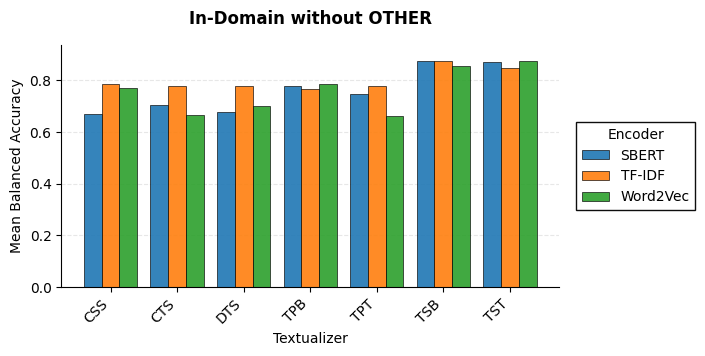

✅ Saved: ../output/paper/bar_plot_in_domain_w_other.pdf


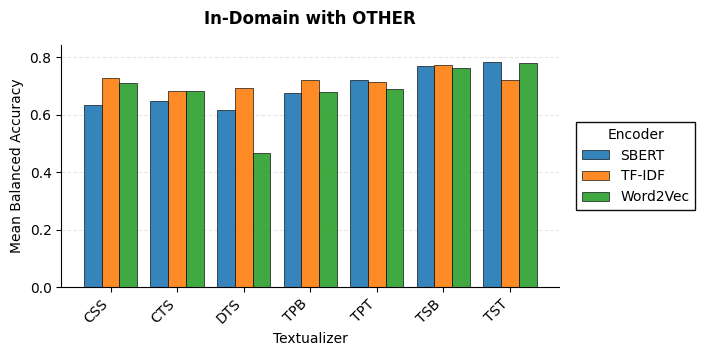

✅ Saved: ../output/paper/bar_plot_cross_domain_wo_other.pdf


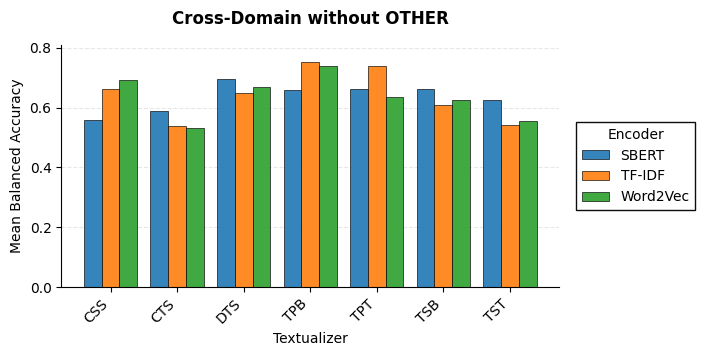

✅ Saved: ../output/paper/bar_plot_cross_domain_w_other.pdf


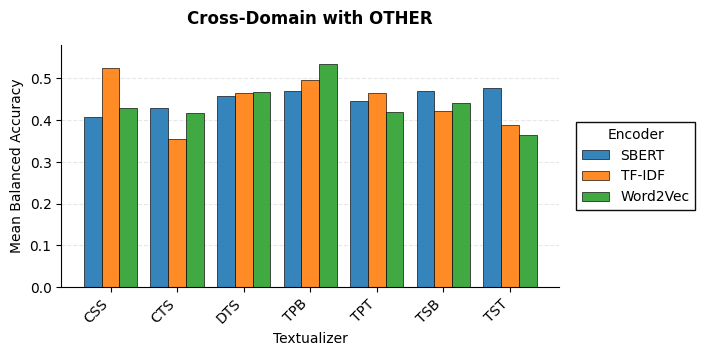

In [8]:
def get_bar_plot(sub, title, filename):
    means = (
        sub.groupby(["textualizer", "encoder"])["balanced_accuracy"]
        .mean()
        .reset_index()
    )
    encoders = sorted(means["encoder"].unique())
    textualizers = sorted(means["textualizer"].unique())
    fig, ax = plt.subplots(figsize=(7, 3.5))
    x = arange(len(textualizers))
    width = 0.8 / len(encoders)
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    for i, enc in enumerate(encoders):
        m = (
            means[means["encoder"] == enc]
            .set_index("textualizer")
            .reindex(textualizers)["balanced_accuracy"]
        )
        offset = width * (i - len(encoders) / 2 + 0.5)
        ax.bar(
            x + offset,
            m,
            width,
            label=enc,
            color=colors[i % len(colors)],
            edgecolor="black",
            linewidth=0.5,
            alpha=0.9,
        )
    ax.set_xlabel("Textualizer", fontweight="normal")
    ax.set_ylabel("Mean Balanced Accuracy", fontweight="normal")
    ax.set_title(title, pad=15, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(textualizers, rotation=45, ha="right")
    ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(max(0, ymin - 0.02), ymax + 0.02)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(
        title="Encoder",
        frameon=True,
        fancybox=False,
        edgecolor="black",
        framealpha=0.95,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
    )
    plt.tight_layout(pad=0.5)
    base_path = outdir / filename
    plt.savefig(f"{base_path}.pdf", bbox_inches="tight", transparent=True)
    print(f"✅ Saved: {base_path}.pdf")
    plt.show()


for subset_key, subset_title in [
    ("in_domain_wo_other", "In-Domain without OTHER"),
    ("in_domain_w_other", "In-Domain with OTHER"),
    ("cross_domain_wo_other", "Cross-Domain without OTHER"),
    ("cross_domain_w_other", "Cross-Domain with OTHER"),
]:
    sub = subsets[subset_key]
    filename = f"bar_plot_{subset_key}"
    get_bar_plot(sub, subset_title, filename)

In [9]:
sources = df["source"].unique()
for source in sources:
    cols_to_drop = ["source", "target", "use_other", "setting", "family"]
    x_w_other = df[
        (df["source"] == source) & (df["target"] == source) & (df["use_other"])
    ].reset_index(drop=True)
    x_w_other.drop(columns=cols_to_drop, inplace=True)
    x_wo_other = df[
        (df["source"] == source) & (df["target"] == source) & (~df["use_other"])
    ].reset_index(drop=True)
    x_wo_other.drop(columns=cols_to_drop, inplace=True)
    in_domain_table = x_wo_other.merge(
        x_w_other,
        on=["textualizer", "encoder"],
        suffixes=("_wo_other", "_w_other"),
    )
    targets = [d for d in sources if d != source]
    cross_domain_tables = []
    for target in sorted(targets):
        x_w_other = df[
            (df["source"] == source) & (df["target"] == target) & (df["use_other"])
        ].reset_index(drop=True)
        x_w_other.drop(columns=cols_to_drop, inplace=True)
        x_wo_other = df[
            (df["source"] == source) & (df["target"] == target) & (~df["use_other"])
        ].reset_index(drop=True)
        x_wo_other.drop(columns=cols_to_drop, inplace=True)
        cross_domain_merged = x_wo_other.merge(
            x_w_other,
            on=["textualizer", "encoder"],
            suffixes=(f"_wo_other_{target}", f"_w_other_{target}"),
        )
        cross_domain_tables.append(cross_domain_merged)
    cross_domain_table = cross_domain_tables[0]
    for df_to_merge in cross_domain_tables[1:]:
        cross_domain_table = cross_domain_table.merge(
            df_to_merge,
            on=["textualizer", "encoder"],
        )
    combined_table = in_domain_table.merge(
        cross_domain_table,
        on=["textualizer", "encoder"],
    )
    abbrev = {
        "Ordonez-A": "OA",
        "Ordonez-B": "OB",
        "CASAS-Aruba": "CA",
        "CASAS-Milan": "CM",
    }
    renamed_columns = {}
    for col in combined_table.columns:
        if col.endswith("_wo_other"):
            renamed_columns[col] = f"{abbrev[source]} → {abbrev[source]}, No OTHER"
        elif col.endswith("_w_other"):
            renamed_columns[col] = f"{abbrev[source]} → {abbrev[source]}, With OTHER"
        elif "_wo_other_" in col:
            parts = col.rsplit("_wo_other_", 1)
            renamed_columns[col] = f"{abbrev[source]} → {abbrev[parts[1]]}, No OTHER"
        elif "_w_other_" in col:
            parts = col.rsplit("_w_other_", 1)
            renamed_columns[col] = f"{abbrev[source]} → {abbrev[parts[1]]}, With OTHER"
        elif col in ["textualizer", "encoder"]:
            renamed_columns[col] = col.capitalize()
    combined_table.rename(columns=renamed_columns, inplace=True)
    combined_table = combined_table.round(3)
    compressed_combined_table = combined_table.copy()
    for col in compressed_combined_table.columns:
        if col not in ["Textualizer", "Encoder"]:
            compressed_combined_table[col] = (
                compressed_combined_table[col]
                .astype(str)
                .apply(lambda x: f"{float(x) * 100:.1f}")
            )
    for target in targets:
        col_wo = f"{abbrev[source]} → {abbrev[target]}, No OTHER"
        col_w = f"{abbrev[source]} → {abbrev[target]}, With OTHER"
        new_col = f"{abbrev[source]} → {abbrev[target]}"
        compressed_combined_table[new_col] = (
            compressed_combined_table[col_wo].astype(str)
            + " / "
            + compressed_combined_table[col_w].astype(str)
        )
        compressed_combined_table.drop(columns=[col_wo, col_w], inplace=True)
    col_wo = f"{abbrev[source]} → {abbrev[source]}, No OTHER"
    col_w = f"{abbrev[source]} → {abbrev[source]}, With OTHER"
    new_col = f"{abbrev[source]} → {abbrev[source]}"
    compressed_combined_table[new_col] = (
        compressed_combined_table[col_wo].astype(str)
        + " / "
        + compressed_combined_table[col_w].astype(str)
    )
    compressed_combined_table.drop(columns=[col_wo, col_w], inplace=True)
    display(compressed_combined_table)

    def convert_combined_table_to_latex(
        table: DataFrame, caption: str, label: str
    ) -> str:
        lines = []
        lines.append("\\begin{table}[htbp]")
        lines.append("\\centering")
        lines.append("\\setlength\\tabcolsep{0pt}")
        lines.append(f"\\caption{{{caption}}}")
        lines.append(f"\\label{{{label}}}")
        lines.append(
            "\\begin{tabular*}{\\columnwidth}{@{}ll"
            + "c" * (len(table.columns) - 2)
            + "@{}}"
        )
        lines.append("\\toprule")
        header_row = " & ".join([f"\\textbf{{{col}}}" for col in table.columns])
        lines.append(header_row + " \\\\")
        lines.append("\\midrule")
        for idx, row in table.iterrows():
            row_values = " & ".join([str(row[col]) for col in table.columns])
            lines.append(row_values + " \\\\")
        lines.append("\\bottomrule")
        lines.append("\\end{tabular*}")
        lines.append("\\end{table}")
        latex_content = "\n".join(lines)
        return latex_content

    latex_table = convert_combined_table_to_latex(
        compressed_combined_table,
        caption=f"Performance of all textualizer + encoder configurations for source dataset {source}. Values are reported as Balanced Accuracy (BA) in percentage (%), formatted as 'No OTHER / With OTHER'.",
        label=f"tab:all_configs_{abbrev[source]}",
    )
    print(latex_table)

,Textualizer,Encoder,CA → CM,CA → OA,CA → OB,CA → CA
0,CTS,SBERT,60.6 / 23.7,43.1 / 27.4,46.4 / 22.8,80.1 / 64.1
1,CTS,TF-IDF,58.2 / 34.3,19.5 / 16.0,31.8 / 22.9,71.6 / 65.5
2,CTS,Word2Vec,63.8 / 31.6,49.2 / 16.7,14.8 / 18.1,74.2 / 63.4
3,CSS,SBERT,64.0 / 39.4,47.1 / 39.7,53.4 / 37.4,74.1 / 65.7
4,CSS,TF-IDF,63.0 / 49.1,44.0 / 36.9,60.5 / 32.2,82.6 / 72.6
5,CSS,Word2Vec,75.0 / 37.8,55.7 / 19.1,63.1 / 25.6,73.3 / 60.6
6,DTS,SBERT,55.5 / 36.0,59.2 / 50.7,56.2 / 47.6,75.8 / 63.1
7,DTS,TF-IDF,40.8 / 38.4,59.7 / 51.3,51.0 / 53.5,77.6 / 70.2
8,DTS,Word2Vec,57.7 / 24.3,59.5 / 59.5,56.8 / 43.9,79.0 / 61.3
9,TPB,SBERT,70.6 / 41.8,57.0 / 34.8,55.1 / 28.7,77.7 / 64.6


\begin{table}[htbp]
\centering
\setlength\tabcolsep{0pt}
\caption{Performance of all textualizer + encoder configurations for source dataset CASAS-Aruba. Values are reported as Balanced Accuracy (BA) in percentage (%), formatted as 'No OTHER / With OTHER'.}
\label{tab:all_configs_CA}
\begin{tabular*}{\columnwidth}{@{}llcccc@{}}
\toprule
\textbf{Textualizer} & \textbf{Encoder} & \textbf{CA → CM} & \textbf{CA → OA} & \textbf{CA → OB} & \textbf{CA → CA} \\
\midrule
CTS & SBERT & 60.6 / 23.7 & 43.1 / 27.4 & 46.4 / 22.8 & 80.1 / 64.1 \\
CTS & TF-IDF & 58.2 / 34.3 & 19.5 / 16.0 & 31.8 / 22.9 & 71.6 / 65.5 \\
CTS & Word2Vec & 63.8 / 31.6 & 49.2 / 16.7 & 14.8 / 18.1 & 74.2 / 63.4 \\
CSS & SBERT & 64.0 / 39.4 & 47.1 / 39.7 & 53.4 / 37.4 & 74.1 / 65.7 \\
CSS & TF-IDF & 63.0 / 49.1 & 44.0 / 36.9 & 60.5 / 32.2 & 82.6 / 72.6 \\
CSS & Word2Vec & 75.0 / 37.8 & 55.7 / 19.1 & 63.1 / 25.6 & 73.3 / 60.6 \\
DTS & SBERT & 55.5 / 36.0 & 59.2 / 50.7 & 56.2 / 47.6 & 75.8 / 63.1 \\
DTS & TF-IDF & 40.8 / 38.4 &

,Textualizer,Encoder,CM → CA,CM → OA,CM → OB,CM → CM
0,CTS,SBERT,53.0 / 43.4,45.3 / 38.9,39.9 / 33.1,59.4 / 50.6
1,CTS,TF-IDF,64.8 / 30.7,34.3 / 27.3,40.5 / 24.2,63.7 / 51.5
2,CTS,Word2Vec,65.6 / 46.2,44.8 / 30.8,38.7 / 27.3,62.3 / 45.5
3,CSS,SBERT,58.7 / 39.7,44.6 / 42.7,37.8 / 37.5,61.5 / 49.9
4,CSS,TF-IDF,56.6 / 47.6,58.1 / 34.4,55.2 / 30.0,61.4 / 46.7
5,CSS,Word2Vec,59.7 / 46.8,50.6 / 26.3,39.8 / 25.4,61.1 / 50.2
6,DTS,SBERT,65.7 / 14.6,81.4 / 33.6,64.3 / 36.9,55.7 / 27.7
7,DTS,TF-IDF,61.5 / 18.7,76.6 / 22.1,72.6 / 35.3,66.9 / 52.9
8,DTS,Word2Vec,57.6 / 14.5,81.4 / 33.6,72.7 / 36.9,49.3 / 23.4
9,TPB,SBERT,56.9 / 46.4,50.0 / 29.8,37.5 / 22.6,60.8 / 45.6


\begin{table}[htbp]
\centering
\setlength\tabcolsep{0pt}
\caption{Performance of all textualizer + encoder configurations for source dataset CASAS-Milan. Values are reported as Balanced Accuracy (BA) in percentage (%), formatted as 'No OTHER / With OTHER'.}
\label{tab:all_configs_CM}
\begin{tabular*}{\columnwidth}{@{}llcccc@{}}
\toprule
\textbf{Textualizer} & \textbf{Encoder} & \textbf{CM → CA} & \textbf{CM → OA} & \textbf{CM → OB} & \textbf{CM → CM} \\
\midrule
CTS & SBERT & 53.0 / 43.4 & 45.3 / 38.9 & 39.9 / 33.1 & 59.4 / 50.6 \\
CTS & TF-IDF & 64.8 / 30.7 & 34.3 / 27.3 & 40.5 / 24.2 & 63.7 / 51.5 \\
CTS & Word2Vec & 65.6 / 46.2 & 44.8 / 30.8 & 38.7 / 27.3 & 62.3 / 45.5 \\
CSS & SBERT & 58.7 / 39.7 & 44.6 / 42.7 & 37.8 / 37.5 & 61.5 / 49.9 \\
CSS & TF-IDF & 56.6 / 47.6 & 58.1 / 34.4 & 55.2 / 30.0 & 61.4 / 46.7 \\
CSS & Word2Vec & 59.7 / 46.8 & 50.6 / 26.3 & 39.8 / 25.4 & 61.1 / 50.2 \\
DTS & SBERT & 65.7 / 14.6 & 81.4 / 33.6 & 64.3 / 36.9 & 55.7 / 27.7 \\
DTS & TF-IDF & 61.5 / 18.7 &

,Textualizer,Encoder,OA → CA,OA → CM,OA → OB,OA → OA
0,CTS,SBERT,68.6 / 42.7,60.7 / 48.7,75.5 / 64.6,85.3 / 79.5
1,CTS,TF-IDF,48.6 / 17.1,22.7 / 15.5,77.7 / 48.7,92.0 / 84.6
2,CTS,Word2Vec,70.4 / 39.4,59.3 / 40.0,86.3 / 63.0,69.6 / 85.7
3,CSS,SBERT,39.7 / 32.9,39.1 / 27.4,77.1 / 41.1,63.6 / 66.1
4,CSS,TF-IDF,72.3 / 62.7,65.3 / 66.1,88.3 / 75.3,95.8 / 89.3
5,CSS,Word2Vec,78.5 / 36.8,75.2 / 37.8,92.3 / 60.4,95.8 / 84.6
6,DTS,SBERT,79.5 / 56.3,60.9 / 42.5,69.7 / 61.3,87.5 / 79.4
7,DTS,TF-IDF,55.6 / 53.5,57.7 / 44.0,78.8 / 64.3,90.8 / 87.7
8,DTS,Word2Vec,66.6 / 49.4,62.7 / 52.3,73.9 / 72.6,81.5 / 50.2
9,TPB,SBERT,73.1 / 50.4,60.2 / 55.4,74.9 / 66.6,87.5 / 90.6


\begin{table}[htbp]
\centering
\setlength\tabcolsep{0pt}
\caption{Performance of all textualizer + encoder configurations for source dataset Ordonez-A. Values are reported as Balanced Accuracy (BA) in percentage (%), formatted as 'No OTHER / With OTHER'.}
\label{tab:all_configs_OA}
\begin{tabular*}{\columnwidth}{@{}llcccc@{}}
\toprule
\textbf{Textualizer} & \textbf{Encoder} & \textbf{OA → CA} & \textbf{OA → CM} & \textbf{OA → OB} & \textbf{OA → OA} \\
\midrule
CTS & SBERT & 68.6 / 42.7 & 60.7 / 48.7 & 75.5 / 64.6 & 85.3 / 79.5 \\
CTS & TF-IDF & 48.6 / 17.1 & 22.7 / 15.5 & 77.7 / 48.7 & 92.0 / 84.6 \\
CTS & Word2Vec & 70.4 / 39.4 & 59.3 / 40.0 & 86.3 / 63.0 & 69.6 / 85.7 \\
CSS & SBERT & 39.7 / 32.9 & 39.1 / 27.4 & 77.1 / 41.1 & 63.6 / 66.1 \\
CSS & TF-IDF & 72.3 / 62.7 & 65.3 / 66.1 & 88.3 / 75.3 & 95.8 / 89.3 \\
CSS & Word2Vec & 78.5 / 36.8 & 75.2 / 37.8 & 92.3 / 60.4 & 95.8 / 84.6 \\
DTS & SBERT & 79.5 / 56.3 & 60.9 / 42.5 & 69.7 / 61.3 & 87.5 / 79.4 \\
DTS & TF-IDF & 55.6 / 53.5 & 5

,Textualizer,Encoder,OB → CA,OB → CM,OB → OA,OB → OB
0,CTS,SBERT,59.5 / 39.3,57.6 / 51.4,96.8 / 79.4,57.1 / 64.8
1,CTS,TF-IDF,78.0 / 54.3,73.1 / 63.4,98.3 / 70.9,83.7 / 71.4
2,CTS,Word2Vec,35.4 / 42.8,44.4 / 58.4,64.8 / 85.7,59.8 / 78.4
3,CSS,SBERT,59.0 / 36.3,52.6 / 33.4,96.9 / 80.5,68.8 / 71.5
4,CSS,TF-IDF,61.3 / 44.4,76.3 / 64.9,93.0 / 85.3,74.6 / 82.8
5,CSS,Word2Vec,79.5 / 49.2,78.1 / 64.9,81.6 / 86.3,77.3 / 87.8
6,DTS,SBERT,87.4 / 45.5,58.7 / 54.1,98.1 / 71.2,51.6 / 75.7
7,DTS,TF-IDF,60.8 / 50.7,65.4 / 54.1,98.3 / 71.1,76.2 / 66.8
8,DTS,Word2Vec,72.0 / 51.4,61.8 / 51.0,81.4 / 71.7,71.0 / 51.4
9,TPB,SBERT,87.1 / 46.9,69.5 / 55.1,99.2 / 85.2,85.3 / 69.9


\begin{table}[htbp]
\centering
\setlength\tabcolsep{0pt}
\caption{Performance of all textualizer + encoder configurations for source dataset Ordonez-B. Values are reported as Balanced Accuracy (BA) in percentage (%), formatted as 'No OTHER / With OTHER'.}
\label{tab:all_configs_OB}
\begin{tabular*}{\columnwidth}{@{}llcccc@{}}
\toprule
\textbf{Textualizer} & \textbf{Encoder} & \textbf{OB → CA} & \textbf{OB → CM} & \textbf{OB → OA} & \textbf{OB → OB} \\
\midrule
CTS & SBERT & 59.5 / 39.3 & 57.6 / 51.4 & 96.8 / 79.4 & 57.1 / 64.8 \\
CTS & TF-IDF & 78.0 / 54.3 & 73.1 / 63.4 & 98.3 / 70.9 & 83.7 / 71.4 \\
CTS & Word2Vec & 35.4 / 42.8 & 44.4 / 58.4 & 64.8 / 85.7 & 59.8 / 78.4 \\
CSS & SBERT & 59.0 / 36.3 & 52.6 / 33.4 & 96.9 / 80.5 & 68.8 / 71.5 \\
CSS & TF-IDF & 61.3 / 44.4 & 76.3 / 64.9 & 93.0 / 85.3 & 74.6 / 82.8 \\
CSS & Word2Vec & 79.5 / 49.2 & 78.1 / 64.9 & 81.6 / 86.3 & 77.3 / 87.8 \\
DTS & SBERT & 87.4 / 45.5 & 58.7 / 54.1 & 98.1 / 71.2 & 51.6 / 75.7 \\
DTS & TF-IDF & 60.8 / 50.7 & 6

✅ Saved: css_ablation_delta_no_other.pdf


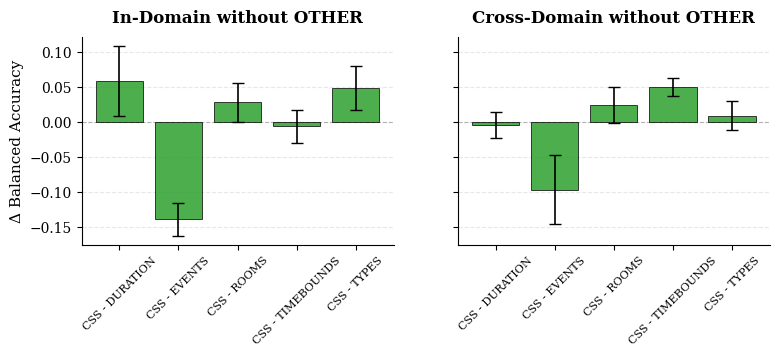

✅ Saved: css_ablation_delta_with_other.pdf


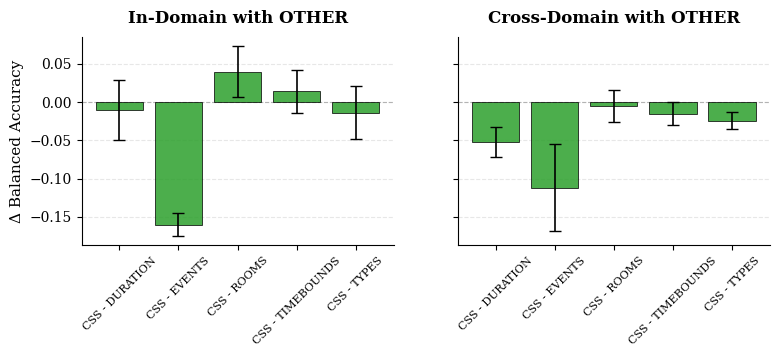

In [10]:
df = read_csv("../imported/tidy_results_ablation.csv")
df.columns = [c.strip().lower() for c in df.columns]
df = df[df["encoder"].str.contains("tfidf", case=False, na=False)]
name_map = {
    "CompoundTextualSummary": "CSS - FULL",
    "CompoundTextualSummaryNoType": "CSS - TYPES",
    "CompoundTextualSummaryNoRoom": "CSS - ROOMS",
    "CompoundTextualSummaryNoDuration": "CSS - DURATION",
    "CompoundTextualSummaryNoTime": "CSS - TIMEBOUNDS",
    "CompoundTextualSummaryNoTokens": "CSS - EVENTS",
}
df = df[df["textualizer"].isin(name_map.keys())].copy()
df["variant"] = df["textualizer"].map(name_map)
df["balanced_accuracy"] = to_numeric(df["balanced_accuracy"], errors="coerce")
df = df.dropna(subset=["balanced_accuracy"])
df["setting"] = df["setting"].str.lower().str.replace(" ", "_")
df["use_other"] = (
    df["use_other"].astype(str).str.upper().map({"TRUE": True, "FALSE": False})
)
df["condition"] = [
    ("in" if "in_domain" in s else "cross") + ("_other" if u else "_no_other")
    for s, u in zip(df["setting"], df["use_other"])
]
variants = [
    "CSS - FULL",
    "CSS - ROOMS",
    "CSS - TYPES",
    "CSS - DURATION",
    "CSS - TIMEBOUNDS",
    "CSS - EVENTS",
]
conditions = ["in_no_other", "cross_no_other", "in_other", "cross_other"]
group = df.groupby(["condition", "source", "target", "variant"], as_index=False)[
    "balanced_accuracy"
].mean()
group["subject"] = group["source"] + "_" + group["target"]
figs = {
    "no_other": ["in_no_other", "cross_no_other"],
    "with_other": ["in_other", "cross_other"],
}
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Times New Roman", "DejaVu Serif"]
mpl.rcParams["font.size"] = 10
mpl.rcParams["axes.labelsize"] = 11
mpl.rcParams["axes.titlesize"] = 12
mpl.rcParams["xtick.labelsize"] = 9
mpl.rcParams["ytick.labelsize"] = 10
mpl.rcParams["legend.fontsize"] = 9
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
for tag, conds in figs.items():
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)
    fig.subplots_adjust(wspace=8)
    for ax, cond in zip(axes, conds):
        sub = group[group["condition"] == cond]
        piv = sub.pivot_table(
            index="subject", columns="variant", values="balanced_accuracy"
        )
        full = piv["CSS - FULL"]
        deltas = {v: (piv[v] - full).mean() for v in piv.columns if v != "CSS - FULL"}
        yerr = [
            (piv[v] - full).std() / sqrt(len(full))
            for v in piv.columns
            if v != "CSS - FULL"
        ]
        variant_labels = list(deltas.keys())
        ax.axhline(0, ls="--", c="gray", linewidth=0.8, alpha=0.5, zorder=1)
        bars = ax.bar(
            range(len(deltas)),
            list(deltas.values()),
            yerr=yerr,
            color="#2ca02c",
            edgecolor="black",
            linewidth=0.6,
            alpha=0.85,
            capsize=4,
            error_kw={"linewidth": 1.2, "ecolor": "black"},
            zorder=2,
        )
        title_map = {
            "in_no_other": "In-Domain without OTHER",
            "cross_no_other": "Cross-Domain without OTHER",
            "in_other": "In-Domain with OTHER",
            "cross_other": "Cross-Domain with OTHER",
        }
        ax.set_title(title_map.get(cond, cond), fontweight="bold", pad=10)
        ax.set_xticks(range(len(variant_labels)))
        ax.set_xticklabels(variant_labels, rotation=45, ha="center", fontsize=8)
        if ax == axes[0]:
            ax.set_ylabel("Δ Balanced Accuracy", fontweight="normal")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.8)
        ax.spines["bottom"].set_linewidth(0.8)
        ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)
        ax.set_axisbelow(True)
    plt.tight_layout(pad=0.5)
    output_path = outdir / f"css_ablation_delta_{tag}.pdf"
    plt.savefig(output_path, bbox_inches="tight", transparent=True)
    print(f"✅ Saved: {output_path.name}")
    plt.show()

In [11]:
df = df.rename(
    columns={
        "use_other": "realism",
        "source": "source_home",
        "target": "target_home",
    }
)
df["realism"] = df["realism"].map(lambda v: "with_other" if bool(v) else "no_other")
variant_map = {
    "CompoundTextualSummary": "full",
    "CompoundTextualSummaryNoRoom": "minus_rooms",
    "CompoundTextualSummaryNoType": "minus_types",
    "CompoundTextualSummaryNoTokens": "minus_events",
    "CompoundTextualSummaryNoDuration": "minus_duration",
    "CompoundTextualSummaryNoTime": "minus_timebounds",
}
df["css_variant"] = df["textualizer"].map(variant_map)
df = df[df["encoder"].str.lower().str.contains("tfidf")].copy()
df = df[df["css_variant"].notna()].copy()


def mean_over_units(d: DataFrame, setting: str) -> float:
    if setting == "in_domain":
        return d.groupby(["source_home"])["balanced_accuracy"].mean().mean()
    else:
        return (
            d.groupby(["source_home", "target_home"])["balanced_accuracy"].mean().mean()
        )


rows = []
for setting in ["in_domain", "cross_domain"]:
    for realism in ["no_other", "with_other"]:
        cell = df[(df["setting"] == setting) & (df["realism"] == realism)].copy()
        if cell.empty:
            continue
        full_cell = cell[cell["css_variant"] == "full"]
        full_mean = mean_over_units(full_cell, setting) if not full_cell.empty else nan
        reduced = cell[cell["css_variant"] != "full"].copy()
        if not reduced.empty:
            means = (
                reduced.groupby("css_variant")
                .apply(lambda d: mean_over_units(d, setting), include_groups=False)  # type: ignore
                .sort_values(ascending=False)
            )
            best_name = means.index[0]
            best_mean = means.iloc[0]
        else:
            best_name, best_mean = None, nan
        rows.append(
            {
                "condition": f"{setting} • {realism}",
                "full_css_mean_ba": round(full_mean, 3) if notna(full_mean) else nan,
                "best_reduced_mean_ba": round(best_mean, 3)
                if notna(best_mean)
                else nan,
                "best_reduced_variant": best_name,
                "delta_best_minus_full": round(best_mean - full_mean, 3)
                if notna(full_mean) and notna(best_mean)
                else nan,
            }
        )

best_table = DataFrame(rows)

order = [
    "in_domain • no_other",
    "in_domain • with_other",
    "cross_domain • no_other",
    "cross_domain • with_other",
]
if not best_table.empty:
    best_table["__order"] = best_table["condition"].apply(
        lambda x: order.index(x) if x in order else 999
    )
    best_table = best_table.sort_values("__order").drop(columns="__order")

display(best_table)


def convert_best_reduced_table_to_latex(
    best_table: DataFrame, caption: str, label: str
) -> str:
    lines = []
    lines.append("\\begin{table}[htbp]")
    lines.append("\\centering")
    lines.append("\\setlength\\tabcolsep{0pt}")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append("\\begin{tabular*}{\\columnwidth}{@{}lcccc@{}}")
    lines.append("\\toprule")
    lines.append(
        "\\textbf{Condition} & \\textbf{Full CSS Mean BA} & \\textbf{Best Reduced Mean BA} & \\textbf{Best Reduced Variant} & \\textbf{Δ Best - Full} \\\\"
    )
    lines.append("\\midrule")
    for idx, row in best_table.iterrows():
        lines.append(
            f"{row['condition']} & {row['full_css_mean_ba']} & {row['best_reduced_mean_ba']} & {row['best_reduced_variant']} & {row['delta_best_minus_full']} \\\\"
        )
    lines.append("\\bottomrule")
    lines.append("\\end{tabular*}")
    lines.append("\\end{table}")
    latex_content = "\n".join(lines)
    return latex_content


best_table_latex = convert_best_reduced_table_to_latex(
    best_table,
    caption="Best reduced CSS variant per condition compared to full CSS. We report mean Balanced Accuracy (BA) over units (sources for in-domain; source-target pairs for cross-domain).",
    label="tab:css_ablation_best_reduced",
)
print(best_table_latex)

,condition,full_css_mean_ba,best_reduced_mean_ba,best_reduced_variant,delta_best_minus_full
0,in_domain • no_other,0.786,0.845,minus_duration,0.059
1,in_domain • with_other,0.728,0.768,minus_rooms,0.040
2,cross_domain • no_other,0.662,0.712,minus_timebounds,0.050
3,cross_domain • with_other,0.524,0.519,minus_rooms,-0.005


\begin{table}[htbp]
\centering
\setlength\tabcolsep{0pt}
\caption{Best reduced CSS variant per condition compared to full CSS. We report mean Balanced Accuracy (BA) over units (sources for in-domain; source-target pairs for cross-domain).}
\label{tab:css_ablation_best_reduced}
\begin{tabular*}{\columnwidth}{@{}lcccc@{}}
\toprule
\textbf{Condition} & \textbf{Full CSS Mean BA} & \textbf{Best Reduced Mean BA} & \textbf{Best Reduced Variant} & \textbf{Δ Best - Full} \\
\midrule
in_domain • no_other & 0.786 & 0.845 & minus_duration & 0.059 \\
in_domain • with_other & 0.728 & 0.768 & minus_rooms & 0.04 \\
cross_domain • no_other & 0.662 & 0.712 & minus_timebounds & 0.05 \\
cross_domain • with_other & 0.524 & 0.519 & minus_rooms & -0.005 \\
\bottomrule
\end{tabular*}
\end{table}


In [12]:


def run_repeated_anova(df: pd.DataFrame, setting: str, realism: str) -> pd.DataFrame:
    sub = df[(df["setting"] == setting) & (df["realism"] == realism)].copy()
    if sub.empty:
        raise ValueError(f"No data for {setting} × {realism}")
    if setting == "in_domain":
        sub["subject"] = sub["source_home"]
    else:
        sub["subject"] = sub["source_home"] + "→" + sub["target_home"]
    aov = pg.rm_anova(
        dv="balanced_accuracy",
        within="css_variant",
        subject="subject",
        data=sub,
        detailed=True
    )

    print(f"\n=== Repeated-measures ANOVA for {setting} × {realism} ===")
    display(aov)
    return aov

anova_results = run_repeated_anova(df, setting="in_domain", realism="no_other")
anova_results = run_repeated_anova(df, setting="in_domain", realism="with_other")
anova_results = run_repeated_anova(df, setting="cross_domain", realism="no_other")
anova_results = run_repeated_anova(df, setting="cross_domain", realism="with_other")


=== Repeated-measures ANOVA for in_domain × no_other ===


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,css_variant,0.103828,5,0.020766,8.34292,0.000608,0.263144,0.470057
1,Error,0.037335,15,0.002489,NaN,NaN,NaN,NaN



=== Repeated-measures ANOVA for in_domain × with_other ===


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,css_variant,0.099290,5,0.019858,13.786087,0.000037,0.195816,0.422389
1,Error,0.021606,15,0.001440,NaN,NaN,NaN,NaN



=== Repeated-measures ANOVA for cross_domain × no_other ===


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,css_variant,0.149847,5,0.029969,3.901102,0.004253,0.092888,0.321122
1,Error,0.422525,55,0.007682,NaN,NaN,NaN,NaN



=== Repeated-measures ANOVA for cross_domain × with_other ===


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,css_variant,0.105659,5,0.021132,2.436484,0.045811,0.04605,0.264142
1,Error,0.477021,55,0.008673,NaN,NaN,NaN,NaN
